In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import prettyplotlib as ppl
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

In [2]:
# read in dataframe
df = pd.read_csv('final_data_files/uncrowded_everything_m4_clipped.csv')#_clipped.csv')

# show column names for reference
print df.columns.values

['id' 'type' 'per' 'mag_j' 'merr_j' 'mag_h' 'merr_h' 'mag_k' 'merr_k'
 'mag_3' 'merr_3' 'mag_4' 'merr_4' 'resid_m4_j' 'resid_m4_h' 'resid_m4_k'
 'resid_m4_3' 'resid_m4_4' 'photfeh' 'photfeh_err' 'spectfeh'
 'spectfeh_err']


In [3]:
dfab = df[df.type == 0]
dfc = df[df.type == 1]

In [4]:
# get color and color error values
df['color'] = df.mag_3 - df.mag_4
df['color_err'] = np.sqrt(df.merr_3**2 + df.merr_4**2)

In [5]:
# select only rows with non-nan residuals; this is equivalent
# to selecting rows with data in all wavelengths
condition_1 = (np.isfinite(df.resid_m4_3))
# select only rows with non-nan spectroscopic metallicities
condition_2 = (np.isfinite(df.spectfeh))
# select only rows with non-nan photometric metallicities
condition_3 = (np.isfinite(df.photfeh))

# create new dataframes based on conditions
# star with id=103 is an outlier so we take it out
# and make a new dataframe with it so it's
# excluded from the linear fit but still plottable
df1 = df[condition_1 & condition_2]
df2 = df[condition_1 & condition_3]

# create lists of values for use in the plotting loop
# order is important here
resids = [df1.resid_m4_3, df2.resid_m4_3, df1.resid_m4_4, df2.resid_m4_4]
fehs = [df1.spectfeh, df2.photfeh, df1.spectfeh, df2.photfeh]
resid_errs = [df1.merr_3, df2.merr_3, df1.merr_4, df2.merr_4]
feh_errs = [df1.spectfeh_err, df2.photfeh_err, df1.spectfeh_err, df2.photfeh_err]

dfs = [df1, df2, df1, df2]

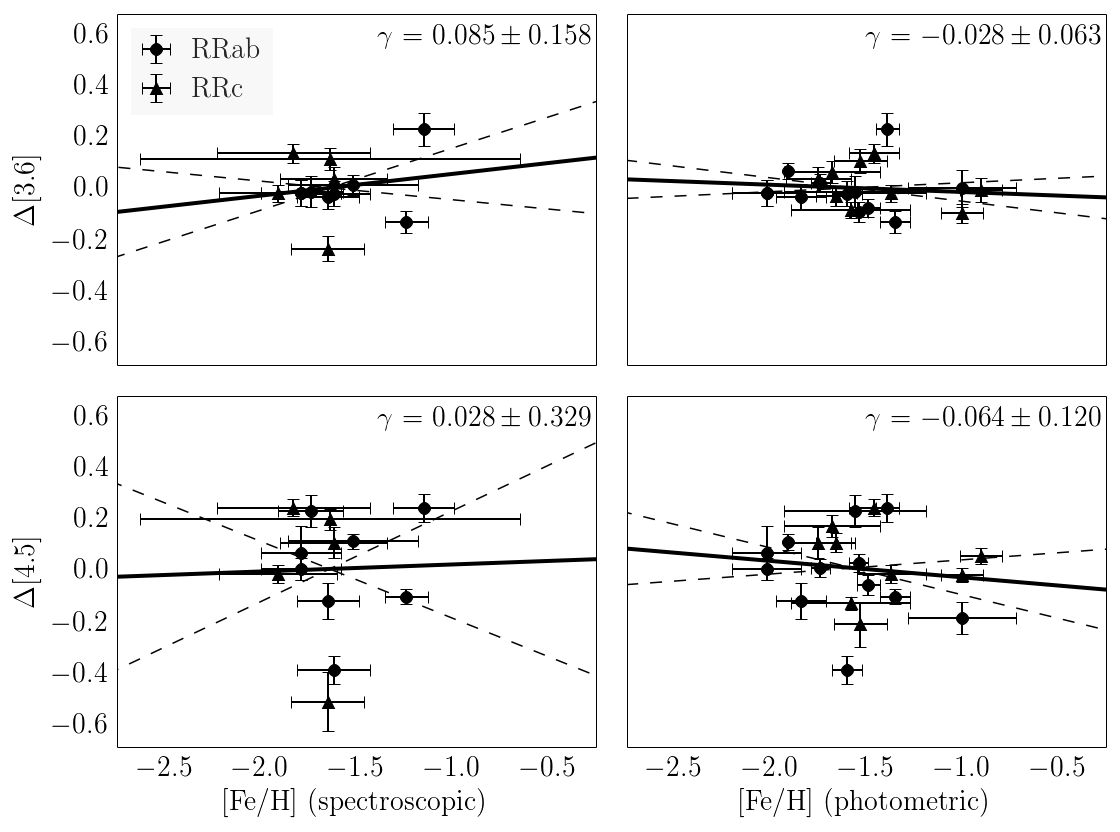

In [6]:
# define line-fitting function
def fitfunc(x,slope,intc):
    return slope*x + intc

# make the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8,6))
ax = [ax1, ax2, ax3, ax4]

# plot the things
for i in range(4):
    ax[i].errorbar(fehs[i][dfs[i].type == 0], resids[i][dfs[i].type == 0],
                   yerr=resid_errs[i][dfs[i].type == 0], xerr = feh_errs[i][dfs[i].type == 0],
                   fmt='o', color='k', label='RRab')
    ax[i].errorbar(fehs[i][dfs[i].type == 1], resids[i][dfs[i].type == 1],
                   yerr=resid_errs[i][dfs[i].type == 1], xerr = feh_errs[i][dfs[i].type == 1],
                   fmt='^', color='k', label='RRc')
    x = np.linspace(-4, 0, 10)
    popt, pcov = curve_fit(fitfunc, fehs[i], resids[i])
    sig = np.sqrt(np.diag(pcov))
    y1 = popt[0] * x + popt[1]
    y2 = (popt[0] + sig[0]) * x + (popt[1] + sig[1])
    y3 = (popt[0] - sig[0]) * x + (popt[1] - sig[1])
    ppl.plot(ax[i],x,y1,'k-',lw=2)
    ppl.plot(ax[i],x,y2,'k--')
    ppl.plot(ax[i],x,y3,'k--')
    ax[i].text(-0.28,0.65,r'$\gamma$ = ${:.3f} \pm {:.3f}$'.format(popt[0], sig[0]),
               va='top', ha='right')
ax3.set_xlabel('[Fe/H] (spectroscopic)')
ax4.set_xlabel('[Fe/H] (photometric)')
ax3.set_ylabel('$\Delta [4.5]$')
ax1.set_ylabel('$\Delta [3.6]$')
ax1.set_ylim(-0.69,0.69)
ax1.set_xlim(-2.75,-0.25)
ppl.legend(ax1, loc=0, prop={'size':14}, numpoints=1, handlelength=1)
fig.tight_layout()
fig.savefig('final_plots/metallicity_vs_residuals_m4_clipped.pdf')

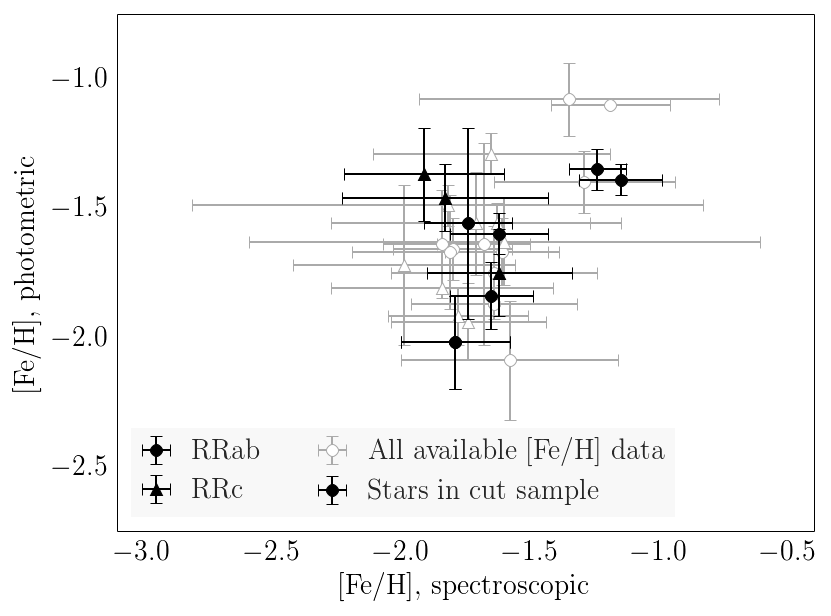

In [7]:
# metallicity comparison plot

df4 = df[condition_1 & condition_2 & condition_3]

df4_ab = df4[df4.type==0]
df4_c = df4[df4.type==1]

df_ab = df[df.type==0]
df_c = df[df.type==1]

color='#AAAAAA'

fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(1,1,1,aspect='equal')
# hack to make correct legend labels
ax.errorbar([], [], xerr = [], yerr = [],
            fmt='o', color='k', ms=6, lw=1, zorder=4,
            label='RRab')
ax.errorbar([], [], xerr = [], yerr = [],
            fmt='^', color='k', ms=6, lw=1, zorder=4,
            label='RRc')
# hack to style plot with prettyplotlib
ppl.plot(ax, [],[])
# actual plotting
ax.errorbar(df_ab.spectfeh, df_ab.photfeh,
            xerr = df_ab.spectfeh_err, yerr = df_ab.photfeh_err,
            fmt='o', mfc='w', mec=color, ms=6, lw=1, color=color,
            label='All available [Fe/H] data')
ax.errorbar(df_c.spectfeh, df_c.photfeh,
            xerr = df_c.spectfeh_err, yerr = df_c.photfeh_err,
            fmt='^', mfc='w', mec=color, ms=6, lw=1, color=color)
ax.errorbar(df4_ab.spectfeh, df4_ab.photfeh,
            xerr = df4_ab.spectfeh_err, yerr = df4_ab.photfeh_err,
            fmt='o', color='k', ms=6, lw=1, zorder=4,
            label='Stars in cut sample')
ax.errorbar(df4_c.spectfeh, df4_c.photfeh,
            xerr = df4_c.spectfeh_err, yerr = df4_c.photfeh_err,
            fmt='^', color='k', ms=6, lw=1, zorder=4)
ax.set_xlabel('[Fe/H], spectroscopic')
ax.set_ylabel('[Fe/H], photometric')
ax.set_xlim(-3.1,-0.4)
ax.set_ylim(-2.75,-0.75)
ppl.legend(ax, loc=0, prop={'size':14}, ncol=2, numpoints=1, handlelength=1)
fig.tight_layout()
fig.savefig('final_plots/metallicity_comparison_all_clipped.pdf')

In [8]:
df1_ab = df1[df1.type == 0]
df1_c = df1[df1.type == 1]
df2_ab = df2[df2.type == 0]
df2_c = df2[df2.type == 1]

print 'Type       mean [Fe/H]     num data points'
print 'Spect_all'.ljust(10), str(np.log10(np.mean(10**df1.spectfeh))).ljust(15), len(df1.spectfeh)
print 'Spect_ab'.ljust(10), str(np.log10(np.mean(10**df1_ab.spectfeh))).ljust(15), len(df1_ab.spectfeh)
print 'Spect_c'.ljust(10), str(np.log10(np.mean(10**df1_c.spectfeh))).ljust(15), len(df1_c.spectfeh)
print 'Phot_all'.ljust(10), str(np.log10(np.mean(10**df2.photfeh))).ljust(15), len(df2.photfeh)
print 'Phot_ab'.ljust(10), str(np.log10(np.mean(10**df2_ab.photfeh))).ljust(15), len(df2_ab.photfeh)
print 'Phot_c'.ljust(10), str(np.log10(np.mean(10**df2_c.photfeh))).ljust(15), len(df2_c.photfeh)

Type       mean [Fe/H]     num data points
Spect_all  -1.56749344383  13
Spect_ab   -1.49561947117  8
Spect_c    -1.71499214554  5
Phot_all   -1.4285055203   21
Phot_ab    -1.5188905482   12
Phot_c     -1.33141497694  9


In [9]:
# distance difference using type abs
lowest_ab = 0.186 * -1.49561947117
highest_ab = 0.186 * -1.5188905482 # -1.73
print lowest_ab - highest_ab

# distance difference using type cs
lowest_c = 0.155 * -1.33141497694
highest_c = 0.155 * -1.71499214554
print lowest_c - highest_c

diff_both = 0.186 * (-1.56749344383 - -1.4285055203)
print diff_both

0.00432842032758
0.059454461133
-0.0258517537766


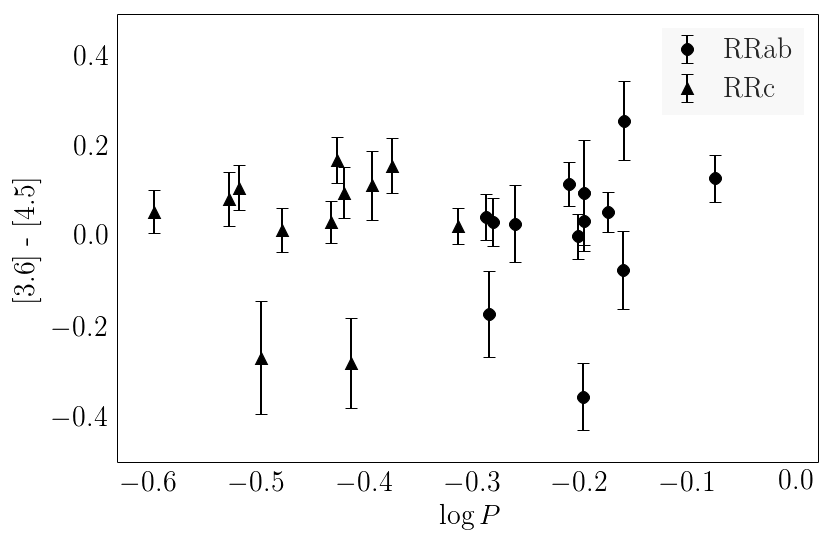

In [10]:
# period color plot

df5 = df[condition_1]

df5_ab = df5[df5.type == 0]
df5_c = df5[df5.type == 1]

color='#AAAAAA'

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# hack to style plot with prettyplotlib
ppl.plot(ax, [],[])
# actual plotting
ax.errorbar(np.log10(df5_ab.per), df5_ab.color,
            yerr = df5_ab.color_err, fmt='o', color='k',
            label='RRab')
ax.errorbar(np.log10(df5_c.per), df5_c.color,
            yerr = df5_c.color_err, fmt='^', color='k',
            label='RRc')
ax.set_xlabel('$\log P$')
ax.set_ylabel('[3.6] - [4.5]')
ax.set_xlim(-0.63, 0.02)
ax.set_ylim(-0.5, 0.5)
ppl.legend(ax, loc=0, prop={'size':14}, numpoints=1, handlelength=1)
fig.tight_layout()
fig.savefig('final_plots/period_color_clipped.pdf')

In [12]:
def calc_feh_err(df, band, m4):
    sig2 = np.std(df['resid_m4_{}'.format(band)])**2
    band2 = np.nanmedian(df['merr_{}'.format(band)])**2
    m42 = (3*m4)**2
    return np.sqrt(sig2 - band2 - m42)

print np.std(df5_ab.resid_m4_3), np.nanmedian(df5_ab.merr_3), 5*0.035, calc_feh_err(df5_ab, 3, 0.035)
print np.std(df5_c.resid_m4_3), np.nanmedian(df5_c.merr_3), 5*0.021, calc_feh_err(df5_c, 3, 0.021)
print np.std(df5_ab.resid_m4_4), np.nanmedian(df5_ab.merr_4), 5*0.036, calc_feh_err(df5_ab, 4, 0.036)
print np.std(df5_c.resid_m4_4), np.nanmedian(df5_c.merr_4), 5*0.021, calc_feh_err(df5_c, 4, 0.021)

0.0843634290098 0.0492273636643 0.175 nan
0.102368199291 0.0407229172466 0.105 0.0696555255307
0.16703153964 0.0426829396051 0.18 0.12005707768
0.201802927279 0.0355994988388 0.105 0.188382847258


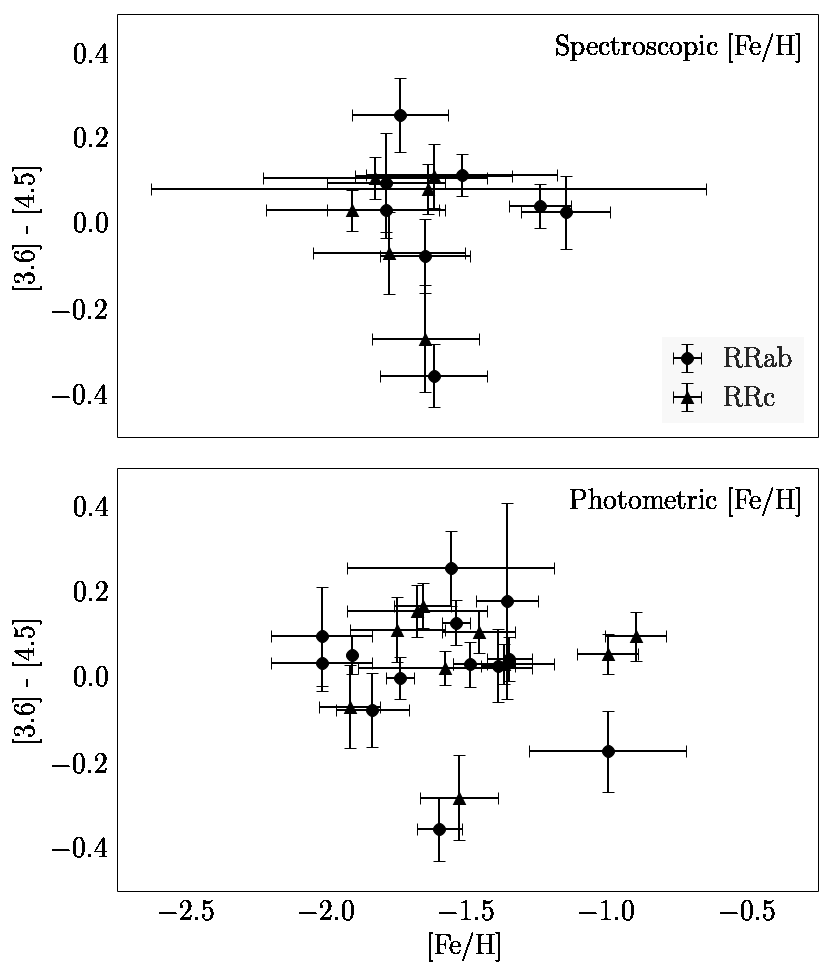

In [14]:
# metallicity color plot

df6 = df[condition_2]

df6_ab = df6[df6.type == 0]
df6_c = df6[df6.type == 1]

df7 = df[condition_3]

df7_ab = df7[df7.type == 0]
df7_c = df7[df7.type == 1]

color='#AAAAAA'

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,7),sharex=True,sharey=True)
# hack to style plot with prettyplotlib
ppl.plot(ax1, [],[])
ppl.plot(ax2, [],[])
# actual plotting
ax1.errorbar(df6_ab.spectfeh, df6_ab.color,
             xerr = df6_ab.spectfeh_err,
             yerr = df6_ab.color_err, fmt='o', color='k',
             label='RRab')
ax1.errorbar(df6_c.spectfeh, df6_c.color,
             xerr = df6_c.spectfeh_err,
             yerr = df6_c.color_err, fmt='^', color='k',
             label='RRc')
ax2.errorbar(df7_ab.photfeh, df7_ab.color,
             xerr = df7_ab.photfeh_err,
             yerr = df7_ab.color_err, fmt='o', color='k',
             label='RRab')
ax2.errorbar(df7_c.photfeh, df7_c.color,
             xerr = df7_c.photfeh_err,
             yerr = df7_c.color_err, fmt='^', color='k',
             label='RRc')
ax2.set_xlabel('[Fe/H]')
ax1.text(-0.3,0.45,'Spectroscopic [Fe/H]',ha='right',va='top')
ax2.text(-0.3,0.45,'Photometric [Fe/H]',ha='right',va='top')
ax1.set_ylabel('[3.6] - [4.5]')
ax2.set_ylabel('[3.6] - [4.5]')
ax1.set_xlim(-2.75,-0.25)
ax1.set_ylim(-0.5,0.5)
ppl.legend(ax1, loc=4, prop={'size':14}, numpoints=1, handlelength=1)
fig.tight_layout()
fig.savefig('final_plots/metallicity_color_clipped.pdf')